In [1]:
!pip install soundfile
!pip install torchaudio
!pip install librosa
!pip install pesq
!pip install pystoi
!pip install livelossplot
!pip install torch_stoi
import torch

     |████████████████████████████████| 3.2MB 2.7MB/s 
     |████████████████████████████████| 81kB 2.2MB/s 
  Created wheel for pesq: filename=pesq-0.0.1-cp36-cp36m-linux_x86_64.whl size=161191 sha256=37345f6e031b33869bf14dc31d09b58e9927c60064b87fe2cbb2da8b05a648d8
  Stored in directory: /root/.cache/pip/wheels/42/a8/44/839b6f59a7d142d84ff06bfabaaad2a3e60408ee153de9bf13
Successfully built pesq
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7782 sha256=1c93a1b9d0b242e94b88c78d123b08325f1c628873fa32e47ce0340aaa04d71a
  Stored in directory: /root/.cache/pip/wheels/6b/6c/b2/d49af4b7ee4ce275cf2511484b043e09b9cb7ae90c1accb17a
Successfully built pystoi
  Created wheel for torch-stoi: filename=torch_stoi-0.1.1-cp36-none-any.whl size=6131 sha256=87002c19d67aae1e08e467e6472840b02f8f99a0551069b02ed80beba7139ca1
  Stored in directory: /root/.cache/pip/wheels/dc/ca/75/e85bd5a7f5874afb25c6255e794a6519013f97962ada51b527
Successfully built torch-stoi


In [4]:
!git config --global user.name AverageName
!cd /content/drive/My\ Drive/Colab\ Notebooks/ && git clone https://github.com/AverageName/Vk_MetricGan.git

Cloning into 'Vk_MetricGan'...
fatal: could not read Username for 'https://github.com': No such device or address


In [0]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
import numpy as np
import librosa
import scipy


def convert_audio_to_array(wav_path):
    samples, sample_rate = sf.read(wav_path)
    return samples, sample_rate

# def visualize_spectr(spectr):
#     f, ax = plt.subplots()
#     ax.set_ylim(0, 65)
#     plt.imshow(spectr, cmap='plasma')

def get_spectr_and_phase(signal, norm=False):
    #print(signal.shape)       
    signal_length = signal.shape[0]
    n_fft = 512
    y_pad = librosa.util.fix_length(signal, signal_length + n_fft // 2)
    
    F = librosa.stft(y_pad, n_fft=512, hop_length=256, win_length=512, window=scipy.signal.hamming)
    
    Lp=np.abs(F)
    phase=np.angle(F)
    if norm == True:    
        meanR = np.mean(Lp, axis=1).reshape((257,1))
        stdR = np.std(Lp, axis=1).reshape((257,1))+1e-12
        NLp = (Lp-meanR)/stdR
    else:
        NLp=Lp
    
    NLp=np.reshape(NLp.T,(1,NLp.shape[1],257)) # For LSTM

    return NLp, phase, signal_length

(38196,)
(1, 151, 257)


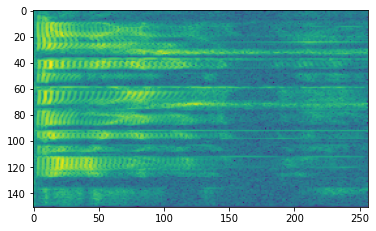

In [0]:
samples, sample_rate = convert_audio_to_array('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/DR7/MSAH1/SI1049.WAV')
NLp, phase, signal_length = get_spectr_and_phase(samples)
print(NLp.shape)
plt.imshow(np.log(np.squeeze(NLp, 0) + 1e-20))

NameError: ignored

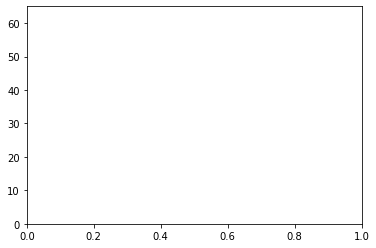

In [0]:
f, ax = plt.subplots()
ax.set_ylim(0, 65)
plt.imshow(np.log(spectr + 1e-10), cmap="plasma")

In [0]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os
import random

In [0]:
def generate_noisy_wavs(path_to_clean_wavs, clean_limit, snrs, path_to_noises, noise_types_wavs, path_to_save):
    clean_wavs = glob.glob(os.path.join(path_to_clean_wavs, '**/*.WAV'), recursive=True)[:clean_limit]
    #print(clean_wavs)
    for clean_wav_path in clean_wavs:
        wav_name = clean_wav_path.rsplit('/', 1)[-1].strip('.WAV')
        clean_folder = clean_wav_path.rsplit('/', 2)[-2]

        if not os.path.exists(os.path.join(path_to_save, "{}_{}".format(clean_folder, wav_name))):
            os.mkdir(os.path.join(path_to_save, "{}_{}".format(clean_folder, wav_name)))

        noisy_folder = os.path.join(path_to_save, "{}_{}".format(clean_folder, wav_name))
        clean_wav, sample_rate_orig = sf.read(clean_wav_path)
        rms_signal = np.mean(clean_wav**2)**(1/2)

        for snr in snrs:
            #for noise_type_wav in noise_types_wavs:
            noise_type_wav = random.choice(noise_types_wavs)
            noise_type_wav = os.path.join(path_to_noises, noise_type_wav)
            noise_name = noise_type_wav.rsplit('/', 1)[-1].strip('.wav')

            noise_wav, sample_rate = sf.read(noise_type_wav)
            rms_noise = np.mean(noise_wav**2)**(1/2)
            rms_noise_should = (rms_signal**2/(10**(snr/10)))**(1/2)
            noise = noise_wav * (rms_noise_should/rms_noise)

            noise_wav = clean_wav + np.concatenate([noise, noise, noise, noise, noise, noise, noise])[:clean_wav.shape[0]]

            sf.write(os.path.join(noisy_folder, 'snr_{}_noise_{}.wav'.format(str(snr), noise_name)), noise_wav, sample_rate_orig)

In [0]:
generate_noisy_wavs('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/', 100, [-10, -5, 0, 5, 10], '/content/drive/My Drive/Nonspeech',
                    ['n2.wav', 'n21.wav', 'n25.wav', 'n32.wav', 'n46.wav', 'n51.wav', 'n65.wav', 'n74.wav', 'n81.wav', 'n90.wav'],
                    '/content/drive/My Drive/val_noisy_wavs/')

In [0]:
samples, sample_rate = convert_audio_to_array('/content/drive/My Drive/noisy_wavs/SX115/snr_4_noise_n1.wav')
print(samples.shape)
# NLp, phase, signal_length = get_spectr_and_phase(samples)
# print(NLp.shape)
# plt.imshow(np.log(np.squeeze(NLp, 0) + 1e-20))

RuntimeError: ignored

In [0]:
class Timit(Dataset):

    def __init__(self, path_to_clean, path_to_noisy):
        
        self.noisy_paths = glob.glob(os.path.join(path_to_noisy, '**/*.wav'), recursive=True)
        #self.num_noises = num_noises
        #self.every = num_noises
        self.path_to_noisy = path_to_noisy
        self.path_to_clean = path_to_clean
    
    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        
        # clean_audio_path = self.clean_paths[idx // self.every]
        # clean_wav_name = clean_audio_path.rsplit('/')[-1].strip('.WAV')
        # clean_folder = clean_audio_path.rsplit('/', 2)[-2]

        #noisy_folder = os.path.join(path_to_save, "{}_{}".format(clean_folder, wav_name))
        #folder_path = os.path.join(self.path_to_noisy, "{}_{}".format(clean_folder, clean_wav_name))
        noisy_audio_path = self.noisy_paths[idx]

        #print(noisy_audio_path)
        clean_audio_folder, clean_wav_name = noisy_audio_path.rsplit('/', 2)[-2].split('_')
        clean_audio_path = glob.glob(os.path.join(self.path_to_clean, '**', clean_audio_folder, clean_wav_name + ".WAV"))[0]
    
        #print(clean_audio_path)
        #print(noisy_audio_path)
        noisy_array, sample_rate = convert_audio_to_array(noisy_audio_path)
        spectr_noisy, phase_noisy, _ = get_spectr_and_phase(noisy_array, norm=True)
        spectr_noisy_wo_norm, _, _ = get_spectr_and_phase(noisy_array, norm=False)
        spectr_noisy_wo_norm = np.squeeze(spectr_noisy_wo_norm, 0)
        spectr_noisy = np.squeeze(spectr_noisy, 0)
        
        array, sample_rate = convert_audio_to_array(clean_audio_path)
        spectr, phase_train, _ = get_spectr_and_phase(array, norm=True)
        spectr_wo_norm, _, _ = get_spectr_and_phase(array, norm=False)
        spectr_wo_norm = np.squeeze(spectr_wo_norm, 0)
        spectr = np.squeeze(spectr, 0)


        return {'clean': spectr, 'noisy': spectr_noisy, 'noisy_wo_norm': spectr_noisy_wo_norm,
                'clean_wo_norm': spectr_wo_norm, 'phase': phase_noisy, 'clean_array': array, 'sample_rate': sample_rate}

In [0]:
train_dataset = Timit('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/', '/content/drive/My Drive/train_noisy_wavs/')

val_dataset = Timit('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/', '/content/drive/My Drive/val_noisy_wavs/')

In [42]:
train_dataset[0]

/content/drive/My Drive/train_noisy_wavs/MTCS0_SA1/snr_-8_noise_n1.wav


{'clean': array([[-0.41607735, -0.88230884, -0.85792476, ..., -0.4506515 ,
         -0.47369975, -0.49286065],
        [-0.308936  , -0.67515785, -0.98400265, ..., -0.4068584 ,
         -0.4729944 , -0.43186685],
        [-0.5080495 , -0.92403656, -0.94264907, ..., -0.4533647 ,
         -0.4424051 , -0.4679093 ],
        ...,
        [ 0.34122595, -0.27858996, -0.70248795, ..., -0.46652326,
         -0.43550956, -0.49773836],
        [ 0.1334326 , -0.4908249 , -0.9542389 , ..., -0.3501657 ,
         -0.4526004 , -0.495242  ],
        [-0.7382131 , -0.64806026, -0.918976  , ..., -0.46975672,
         -0.47686678, -0.48453382]], dtype=float32),
 'clean_array': array([-1.83105469e-04,  6.10351562e-05,  6.10351562e-05, ...,
        -9.15527344e-05,  1.52587891e-04,  2.74658203e-04]),
 'clean_wo_norm': array([[4.7283955e-03, 8.8361365e-04, 2.3146300e-03, ..., 4.0122218e-04,
         2.0884545e-04, 4.1115578e-05],
        [5.4573324e-03, 2.1187030e-03, 1.1511428e-03, ..., 7.3261361e-04,
    

In [0]:
from pystoi import stoi
import soundfile as sf
from torch_stoi import NegSTOILoss
from pesq import pesq
import time

clean_wav = "/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/DR7/MRMG0/SI2340.WAV"
noised_wav = "/content/drive/My Drive/noisy_wavs/MRMG0_SI2340/snr_-4_noise_n1.wav"
#clean, sr = sf.read(clean_wav)
#noised, sr2 = sf.read(noised_wav)
#noised_2, sr3 = librosa.load(noised_wav)
#print(noised_2.shape)
#print(noised.shape)
#print(pesq(16000, clean, noised, 'wb'))
#print(stoi(clean, clean, sr, extended=False))
#print(sr, sr2)
#criterion = NegSTOILoss(sample_rate=sr)
#clean = torch.from_numpy(clean).unsqueeze(0).float()
#clean = clean.type(torch.DoubleTensor)
#noised = torch.from_numpy(noised).unsqueeze(0).float()
#noised = noised.type(torch.DoubleTensor)
#print(criterion(clean, clean))

arr, sr = convert_audio_to_array(clean_wav)
normed, phase, _, = get_spectr_and_phase(arr, norm=True)
unnormed, _, _ = get_spectr_and_phase(arr, norm=False)
print(normed.shape)
Rec = np.multiply(np.squeeze(unnormed.transpose()) , np.exp(1j*phase))
result = librosa.istft(Rec,
                           hop_length=256,
                           win_length=512,
                           window=scipy.signal.hamming, length=arr.shape[0])
print(stoi(arr, result, 16000, extended=False))
# print(signal.shape)
# clean_1d = librosa.istft(signal,hop_length=256,
#                             win_length=512, window=scipy.signal.hamming, length=arr.shape[0])

# stoi(clean_1d, clean_1d, 16000, extended=False)

(1, 223, 257)
0.9999999999999938


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class LstmGen(nn.Module):


    def __init__(self, input_features, hidden_dim, num_layers, fc_hidden_dim):
        super(LstmGen, self).__init__()

        self.lstm = nn.LSTM(input_features, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, input_features)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [0]:
class ConvDiscriminator(nn.Module):

    def __init__(self):
        super(ConvDiscriminator, self).__init__()

        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels=2, out_channels=15,
                                                      kernel_size=(5, 5)))
        
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(in_channels=15, out_channels=25,
                                                      kernel_size=(7, 7)))
        
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels=25, out_channels=40,
                                                      kernel_size=(9, 9)))
        
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(in_channels=40, out_channels=50,
                                                      kernel_size=(11, 11)))
        
        self.fc1 = nn.utils.spectral_norm(nn.Linear(50, 50))
        self.fc2 = nn.utils.spectral_norm(nn.Linear(50, 10))
        self.fc3 = nn.utils.spectral_norm(nn.Linear(10, 1))
        self.bn = nn.BatchNorm2d(2)
    
    def forward(self, x):
        x = self.bn(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)

        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.fc3(x)
        return x

In [0]:
from pesq import pesq
from pystoi import stoi
from torch_stoi import NegSTOILoss

def Q(mode, clean, denoised, sr):
    if mode == "pesq":
        #Figure out wb and nb what is it
        return pesq(sr, clean, denoised, 'wb')
    elif mode == "stoi":
        #criterion = NegSTOILoss(sample_rate=sr)
        #print(criterion(torch.from_numpy(denoised).unsqueeze(0), torch.from_numpy(clean).unsqueeze(0)))
        #return stoi(clean, denoised, sr, extended=False)
        #return -torch.sum(criterion(torch.from_numpy(denoised).unsqueeze(0), torch.from_numpy(clean).unsqueeze(0)))
        #clean = librosa.resample(clean, sr, 10000)
        #denoised = librosa.resample(denoised, sr, 10000)
        return stoi(clean, denoised, 16000, extended=False)

In [0]:
data = train_dataset[0]

In [0]:
a = torch.randn((1, 2, 3)) * -1
print(a)
a = torch.clamp(a, min=0.05)
print(a)

tensor([[[ 2.3439,  0.4998, -1.3999],
         [ 1.4331,  1.1547,  0.5776]]])
tensor([[[2.3439, 0.4998, 0.0500],
         [1.4331, 1.1547, 0.5776]]])


In [0]:
class MetricGan(nn.Module):


    def __init__(self, input_features, hidden_dim, num_layers, fc_hidden_dim, metric, device):
        super(MetricGan, self).__init__()
        self.G = LstmGen(input_features, hidden_dim, num_layers, fc_hidden_dim).to(device)
        self.D = ConvDiscriminator().to(device)
        self.metric = metric
        self.device = device
    
    def forward(self, batch):
        noisy = batch["noisy"].to(self.device)
        noisy_wo_norm = batch["noisy_wo_norm"].to(self.device)

        mask = torch.clamp(self.G(noisy), min=0.05)
        denoised = noisy_wo_norm * mask

        return denoised
    
    def backward_G(self, batch):
        clean_wo_norm = batch["clean_wo_norm"].to(self.device)

        denoised = self.forward(batch)
        logits = self.D(torch.stack([denoised, clean_wo_norm], dim=1))
        #print(logits)
        #Magical number 1
        loss = torch.sum((logits - 1.0)**2)
        loss.backward()
    
        return loss.item()

    def backward_D(self, batch):
        clean_wo_norm = batch["clean_wo_norm"].to(self.device)

        denoised = self.forward(batch).detach()

        logits_noise = self.D(torch.stack([denoised, clean_wo_norm], dim=1))
        logits_clean = self.D(torch.stack([clean_wo_norm, clean_wo_norm], dim=1))

        denoised = np.multiply(denoised.squeeze(0).cpu().numpy().transpose(), np.exp(1j*batch['phase'].numpy()))
        denoised_1d = librosa.istft(np.squeeze(denoised, 0), hop_length=256,
                                    win_length=512, window=scipy.signal.hamming, length=batch['clean_array'].shape[1])
        

        clean_1d = batch['clean_array'].squeeze(0).numpy()

        metrics_noise = Q(self.metric, clean_1d, denoised_1d, batch['sample_rate'])
        
        if self.metric == "pesq":
            metrics_clean = Q(self.metric, clean_1d, clean_1d, batch['sample_rate'])
        else:
            metrics_clean = 1

        loss = (logits_noise - metrics_noise)**2 + (logits_clean - metrics_clean)**2
        loss.backward()

        return loss.item()

In [0]:
#train_dataset = Timit('/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/', '/content/drive/My Drive/noisy_wavs/')
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=2)

In [0]:
import time
def validation_metrics(model, val_dataloader, logs, val_best):

    #running_pesq = 0.0
    running_stoi = 0.0
    stois = []
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            noisy = batch["noisy"].to(model.device)
            clean = batch["clean"].to(model.device)

            denoised = model(batch)
            #print(denoised)
            denoised = np.multiply(denoised.squeeze(0).cpu().numpy().transpose(), np.exp(1j*batch['phase'].numpy()))
            denoised_1d = librosa.istft(np.squeeze(denoised, 0), hop_length=256,
                                    win_length=512, window=scipy.signal.hamming, length=batch['clean_array'].shape[1])
            
            #print(denoised)

            #clean_1d2 = librosa.istft(clean.squeeze(0).cpu().numpy().transpose(), hop_length=256,
                                    #win_length=512, window=scipy.signal.hamming, length=batch['clean_array'].shape[1])
            clean_1d = batch['clean_array'].squeeze(0).numpy()

            #print("Time to convert to 1d arrays: ", time.time() - time_start)
            #time_start = time.time()
            #pesq = Q("pesq", clean_1d, denoised_1d, batch["sample_rate"])
            #print("Time to calc pesq: ", time.time() - time_start)
            #print(denoised_1d)
            stoi = Q("stoi", clean_1d, denoised_1d, batch["sample_rate"])
            stois.append(stoi)
            #print("Time to calc stoi: ", time.time() - time_start)
            #running_pesq += pesq
            running_stoi += stoi
    
    #mean_pesq = running_pesq / len(val_dataloader)
    #print(running_stoi)
    mean_stoi = running_stoi / len(val_dataloader)
    #print("MEAN STOI: ", mean_stoi)
    #print("ARRAY OF STOI: ", stois)

    if mean_stoi > val_best:
        val_best = mean_stoi
        torch.save(model.state_dict(), '/content/drive/My Drive/best_gan_checkp2.pt')

    #logs["val_pesq"] = mean_pesq
    logs["val_stoi"] = mean_stoi

    return logs, val_best


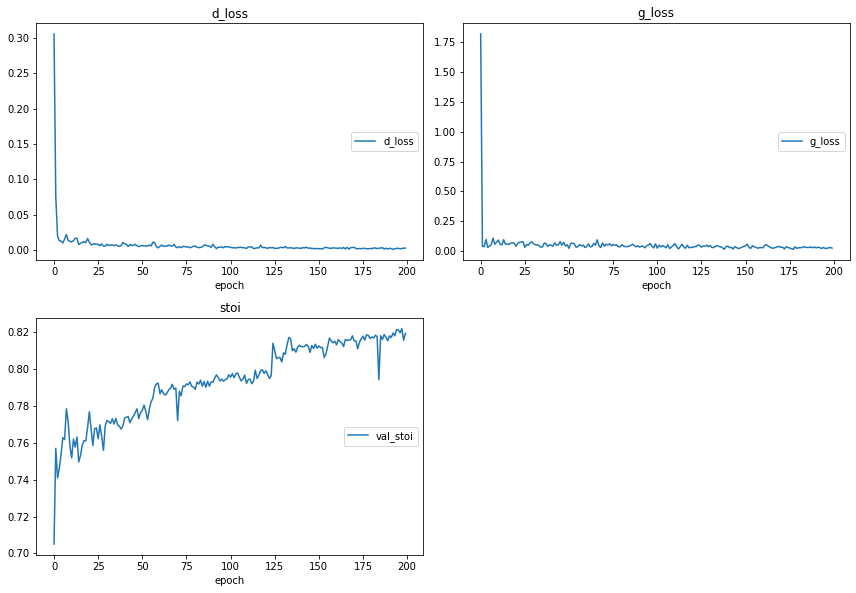

d_loss
	d_loss           	 (min:    0.001, max:    0.305, cur:    0.003)
g_loss
	g_loss           	 (min:    0.015, max:    1.819, cur:    0.025)
stoi
	val_stoi         	 (min:    0.705, max:    0.822, cur:    0.819)


In [61]:
from livelossplot import PlotLosses

model = MetricGan(257, 200, 2, 300, "stoi", device=torch.device("cuda:0"))
#model.load_state_dict(torch.load('/content/drive/My Drive/best_gan_checkp.pt'))
optimizer_g = torch.optim.Adam(model.G.parameters(), betas=[0.5, 0.999], lr=0.0001)
optimizer_d = torch.optim.Adam(model.D.parameters(), lr=0.0001)
epochs = 200
liveloss = PlotLosses()
val_best = 0.0
for epoch in range(epochs):
    logs = {}
    running_loss_g = 0.0
    running_loss_d = 0.0

    for idx, batch in enumerate(train_dataloader):
        if idx < 100:
            optimizer_g.zero_grad()
            loss_g = model.backward_G(batch)
            running_loss_g += loss_g
            optimizer_g.step()

        # noisy = batch["noisy"].to(model.device)
        # clean = batch["clean"].to(model.device)

        # denoised = model.forward(noisy)
        # logits = model.D(torch.stack([denoised, clean], dim=1))
        # print(logits)
        # print("Gen loss: ", loss_g)

        elif idx >= 100 and idx < 200:
            optimizer_d.zero_grad()
            loss_d = model.backward_D(batch)
            running_loss_d += loss_d
            #print("Discr loss: ", loss_d)
            optimizer_d.step()
        else:
            break


        if idx % 50 == 49:
            print(idx + 1)

    logs["g_loss"] = running_loss_g / 100
    logs["d_loss"] = running_loss_d / 100
    print("G loss: ", logs["g_loss"])
    print("D loss: ", logs["d_loss"])
    logs, val_best = validation_metrics(model, val_dataloader, logs, val_best)
    liveloss.update(logs)
    liveloss.send()



In [0]:
np.multiply(np.array([1, 2, 3]), np.exp(1j*np.array([1, 2, 3]))).dtype

dtype('complex128')

In [0]:
from IPython.display import Audio

def enchance_wav(model, wav_path):
    array, sr = convert_audio_to_array(wav_path)

    spectr_without_norm, phase, length = get_spectr_and_phase(array, False)
    spectr, _, _ = get_spectr_and_phase(array, True)

    inputs = torch.from_numpy(spectr).cuda()
    mask = model.G(inputs).detach().cpu().numpy()

    #mask = np.maximum(outputs / spectr, 0.05)
    outputs = np.squeeze(mask * spectr_without_norm)

    enchanced = np.multiply(outputs.transpose() , np.exp(1j*phase))

    denoised_1d = librosa.istft(enchanced, hop_length=256,
                                    win_length=512, window=scipy.signal.hamming, length=length)
    return array, denoised_1d, outputs, spectr_without_norm
    #Audio(data=array, rate=sr)
    #Audio(data=denoised_1d, rate=sr)  # play the audio

In [106]:
%matplotlib inline
model = MetricGan(257, 200, 2, 300, "stoi", device=torch.device("cuda:0"))
model.load_state_dict(torch.load('/content/drive/My Drive/best_gan_checkp2.pt'))

sr = 16000
orig, enchanced, _, _ = enchance_wav(model, "/content/drive/My Drive/val_noisy_wavs/MMLM0_SX87/snr_10_noise_n65.wav")
#orig_clean = "/content/drive/My Drive/data/lisa/data/timit/raw/TIMIT/TRAIN/DR7/MRMG0/SI2340.WAV"
#array_orig_clean, _ = convert_audio_to_array(orig_clean)
#print(stoi(array_orig_clean, enchanced, 16000, extended=False))
print(stoi(orig, enchanced, 16000, extended=False))
Audio(data=orig, rate=sr)

#array, sr = convert_audio_to_array("/content/drive/My Drive/noisy_wavs/MRMG0_SI2340/snr_-4_noise_n1.wav")
#Audio(data=array, rate=sr)
#sf.write('/content/drive/My Drive/orig.wav', orig, samplerate=sr)
#sf.write('/content/drive/My Drive/enchanced.wav', enchanced, samplerate=sr)

0.9784170347856853


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [107]:
Audio(data=enchanced, rate=sr)

In [108]:
orig, enchanced, new_spectr, old_spectr = enchance_wav(model, "/content/drive/My Drive/val_noisy_wavs/MMLM0_SX87/snr_10_noise_n65.wav")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


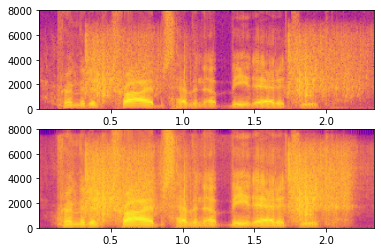

In [114]:
f, (first, second) = plt.subplots(2, 1)
first.specgram(orig, Fs=16000, cmap="plasma")[3]
second.specgram(enchanced, Fs=16000, cmap="plasma")[3]

In [0]:
def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave
    
def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset

In [0]:
model = ConvDiscriminator()
a = torch.randn((1, 2, 500, 257))
print(model(a))

tensor([[0.1368]], grad_fn=<LeakyReluBackward0>)


In [0]:
model = LstmGen(257, 200, 2, 300)
a = torch.randn((1, 500, 257))
print(model(a))

torch.Size([1, 500, 257])
tensor([[[-0.1064,  0.4138, -0.5203,  ..., -0.2862,  0.4930,  0.2462],
         [-0.6437, -0.3689,  0.4594,  ..., -1.3059, -0.2234, -0.1268],
         [ 0.3167,  0.2280,  0.6659,  ..., -0.3588, -1.1962,  0.0530],
         ...,
         [-0.1406, -0.4838,  0.5866,  ..., -0.0838, -0.3212, -0.1926],
         [ 0.4460,  0.2980,  0.3596,  ..., -0.1922,  0.2214,  0.6185],
         [-0.7150, -0.3507, -0.1651,  ..., -0.3028, -0.5590,  0.5683]]],
       grad_fn=<MulBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
for idx, batch in enumerate(train_dataloader):
    print(idx, batch)
    if idx == 5:
        break

0 {'clean': tensor([[[[-0.3018, -0.7264, -0.8602,  ..., -0.3548, -0.2422, -0.1342],
          [-0.2557, -0.5762, -0.6686,  ..., -0.3782, -0.4959, -0.5658],
          [-0.0405, -0.3751, -0.7270,  ..., -0.4051, -0.3583, -0.3090],
          ...,
          [-0.3149, -0.8471,  0.2693,  ..., -0.3685, -0.3921, -0.5349],
          [-0.3645,  0.3681,  0.2477,  ..., -0.2772, -0.3765, -0.4141],
          [-1.3124, -0.9292, -0.7652,  ..., -0.4883, -0.5315, -0.5235]]]]), 'noisy': tensor([[[[9.9944e-02, 1.5714e-01, 1.6217e-01,  ..., 1.2355e-03,
           1.3801e-03, 1.5437e-03],
          [8.3299e-02, 6.6897e-02, 2.5280e-02,  ..., 1.3239e-03,
           1.3791e-03, 9.8072e-05],
          [4.0976e-02, 7.6795e-02, 5.7424e-02,  ..., 2.8318e-04,
           2.7934e-04, 1.8911e-03],
          ...,
          [6.9777e-02, 1.2769e-01, 1.1584e-01,  ..., 1.6614e-03,
           1.5241e-03, 9.0418e-04],
          [1.9427e-02, 5.3267e-02, 7.5856e-02,  ..., 3.9795e-03,
           3.6124e-03, 4.5446e-03],
        